In [1]:
%autosave 1800
%matplotlib inline
from helpers.gym_render import display_frames_as_gif
import matplotlib.pyplot as plt
import gym
from hyperdash import monitor_cell
import numpy as np

Autosaving every 1800 seconds


In [2]:
import torch
import torch.nn.functional as F

In [3]:
env = gym.make('CartPole-v0').unwrapped

[2017-07-31 15:04:18,014] Making new env: CartPole-v0


In [4]:
# confirm cuda
if torch.cuda.is_available():
    print("Cuda ready")
    
use_cuda = True
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Cuda ready


In [5]:
# Store state transitions for reuse later
# Sample randomly to decorrelate transitions in batch

from collections import namedtuple

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        """saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [52]:
## Hyper params

KER_SI = 5
STRIDE = 2

CH = 32 #base number of channels
CH_2 = CH * 2
HEAD = CH * 6

class DQN(torch.nn.Module):
    def __init__(self): # 3 conv w/ batch norm -> Linear layer
        super(DQN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, CH, kernel_size=KER_SI, stride=STRIDE)
        self.bn1 = torch.nn.BatchNorm2d(CH)
        self.conv2 = torch.nn.Conv2d(CH, CH_2, kernel_size=KER_SI, stride=STRIDE)
        self.bn2 = torch.nn.BatchNorm2d(CH_2)
        self.conv3 = torch.nn.Conv2d(CH_2, CH_2, kernel_size=KER_SI, stride=STRIDE)
        self.bn3 = torch.nn.BatchNorm2d(CH_2)
#         self.lin1 = torch.nn.Linear(HEAD, HEAD)
        self.head = torch.nn.Linear(HEAD, 2) #left / right

    def forward(self, x):
        x = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        x = torch.nn.functional.relu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [53]:
env.reset()

array([ 0.04812388, -0.04385895,  0.03194984,  0.00392383])

In [54]:
import torchvision.transforms as T
from PIL import Image
IMAGE_WIDTH = 30
resize = T.Compose([T.ToPILImage(),
                    T.Scale(IMAGE_WIDTH, interpolation=Image.CUBIC),
                    T.ToTensor()])
def get_screen(env):
    # transpose into torch order (CHW)
    screen = env.render(mode='rgb_array').transpose((2, 0, 1)) 
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
#     print(screen.cpu().numpy().shape)
    # Resize, and add a batch dimension (BCHW)
    screen = resize(screen).unsqueeze(0).type(FloatTensor)
    return screen
# get_screen(env)

<generator object parameters at 0x7fbcad2b4a00>
Mean duration over past 100 eps: 106.212121212 - episode 301
Mean duration over past 100 eps: 102.444444444 - episode 401


In [55]:
from torch.autograd import Variable

BATCH_SIZE = 256
GAMMA = 0.999
EPS_START = 0.2
EPS_END = 0.0001
EPS_DECAY = 200
MEMORY = 1000000

model = DQN()
if use_cuda:
     model.cuda()

#A
optims = ["torch.optim.Adam(model.parameters())", "torch.optim.SGD(model.parameters())"]        
optimizer = distrib.prop("optim", optimizers, mode="code")

#B
optim = distrib.prop("optim", ["Adam", "SGD"])
if optim == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif optim == "SGD":
    optimizer = torch.optim.SGD(model.parameters())


optimizer = torch.optim.Adam(model.parameters())
memory = ReplayMemory(MEMORY)

steps_done = 0
thresholds = []
def select_action(state):
    global steps_done
    sample = random.random()
    # epsilon greedy policy
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    thresholds.append(eps_threshold)
    steps_done += 1
    if sample > eps_threshold:
        q = model(Variable(state, volatile=True).type(FloatTensor))
        return q.data.max(1)[1].view(1,1)
    else:
        return LongTensor([[random.randrange(2)]]) # random action
    
episode_durations = []

In [56]:
# Helper
from IPython import display

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [57]:
def optimize_model():
    if len(memory) < BATCH_SIZE: #skip first batch
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None, 
                                          batch.next_state)))
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                               if s is not None]),
                                     volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = model(state_batch).gather(1, action_batch)
    
    # Computer V(s_{t+1}) for all next states
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(FloatTensor))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    
    next_state_values.volatile = False
    # Compute expected Q vals
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1,1)
    optimizer.step()
    

In [58]:
import math
import random
from itertools import count


In [59]:
%%monitor_cell "DQN Cartpole"
NUM_EPISODES = 800
print("Setting up with hyperparams:")
print("Episodes",NUM_EPISODES)
print("Kernal size", KER_SI)
print("Stride",STRIDE)
print("Base conv nodes", CH)
print("Middle conv nodes", CH_2)
print("Head nodes",HEAD)
print("Batch size", BATCH_SIZE)
print("MEMORY", MEMORY)
print("Gamma", GAMMA)
print("Epsilon start", EPS_START)
print("Epsilon end", EPS_END)
print("Epsilon decay", EPS_DECAY)
print("Image width",IMAGE_WIDTH)
print(episode_durations)

good_runs = []
weak_runs = []
for ep in range (NUM_EPISODES):
    env.reset()
    last_screen = get_screen(env)
    current_screen = get_screen(env)
    state = current_screen - last_screen
    frames = []
    record = False

    for t in count():
        action = select_action(state)
        _, reward, done, _ = env.step(action[0,0])
        reward = FloatTensor([reward])
        last_screen = current_screen
        current_screen = get_screen(env)
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        memory.push(state, action, next_state, reward)
        if record:
            frames.append(np.squeeze(current_screen.cpu().numpy(), axis=0).swapaxes(0,2).swapaxes(0,1))
        
        state = next_state
#         show_state(env, t)
        optimize_model()
        if done:
            episode_durations.append(t+1)
#             plot_durations()
            if ep % 100 == 0 and ep != 0:
                recent = episode_durations[-99:]
                print("Mean duration over past 100 eps: {} - episode {}".format(np.mean(recent), len(episode_durations)))
            if record:
                if t > 100:
                    good_runs.append(frames)
                    print("good run", len(good_runs))
                elif ep > 200 and t > 25 and t < 40:
                    weak_runs.append(frames)
                    print("Weak run", len(weak_runs))
            break
            
print("Done! Total episodes", len(episode_durations))
print("Max duration", max(episode_durations))
print("Average duration", np.mean(episode_durations))
print("Average last 50 duration", np.mean(episode_durations[-50:]))
solved = [x for x in episode_durations if x > 194]
print("Times solved", len(solved))
env.render(close=True)
env.close()
        
        

Setting up with hyperparams:
('Episodes', 800)
('Kernal size', 5)
('Stride', 2)
('Base conv nodes', 32)
('Middle conv nodes', 64)
('Head nodes', 192)
('Batch size', 256)
('MEMORY', 1000000)
('Gamma', 0.999)
('Epsilon start', 0.2)
('Epsilon end', 0.0001)
('Epsilon decay', 200)
('Image width', 30)
[]


SystemExit: 130

/home/paperspace/anaconda2/envs/p27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Mean duration over past 100 eps: 43.4242424242 - episode 101


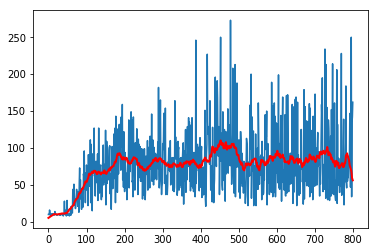

In [27]:

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.plot(episode_durations)
plt.plot(smooth(episode_durations,30), "r-", lw=2)
plt.show()

In [ ]:
all_f = [frame for video in good_runs for frame in video]

In [ ]:
display_frames_as_gif(all_f)

In [ ]:
# for i in range(len(good_runs)):
#     display_frames_as_gif(good_runs[i])